In [13]:
# prepare data for lstm
from pandas import read_csv
from pandas import DataFrame
from pandas import concat
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential

In [2]:
# convert series to supervised learning
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
	n_vars = 1 if type(data) is list else data.shape[1]
	df = DataFrame(data)
	cols, names = list(), list()
	# input sequence (t-n, ... t-1)
	for i in range(n_in, 0, -1):
		cols.append(df.shift(i))
		names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
	# forecast sequence (t, t+1, ... t+n)
	for i in range(0, n_out):
		cols.append(df.shift(-i))
		if i == 0:
			names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
		else:
			names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
	# put it all together
	agg = concat(cols, axis=1)
	agg.columns = names
	# drop rows with NaN values
	if dropnan:
		agg.dropna(inplace=True)
	return agg

In [4]:
# load dataset
dataset = read_csv('data/pollution.csv', header=0, index_col=0)
values = dataset.values

In [5]:
# integer encode direction
encoder = LabelEncoder()
values[:,4] = encoder.fit_transform(values[:,4])

In [6]:
# ensure all data is float
values = values.astype('float32')

In [7]:
# normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)

In [8]:
# frame as supervised learning
reframed = series_to_supervised(scaled, 1, 1)

In [9]:
# drop columns we don't want to predict
reframed.drop(reframed.columns[[9,10,11,12,13,14,15]], axis=1, inplace=True)
print(reframed.head())

   var1(t-1)  var2(t-1)  var3(t-1)  var4(t-1)  var5(t-1)  var6(t-1)  \
1   0.129779   0.352941   0.245902   0.527273   0.666667   0.002290   
2   0.148893   0.367647   0.245902   0.527273   0.666667   0.003811   
3   0.159960   0.426471   0.229508   0.545454   0.666667   0.005332   
4   0.182093   0.485294   0.229508   0.563637   0.666667   0.008391   
5   0.138833   0.485294   0.229508   0.563637   0.666667   0.009912   

   var7(t-1)  var8(t-1)   var1(t)  
1   0.000000        0.0  0.148893  
2   0.000000        0.0  0.159960  
3   0.000000        0.0  0.182093  
4   0.037037        0.0  0.138833  
5   0.074074        0.0  0.109658  


In [32]:
# split into train and test sets
values = reframed.values
n_train_hours = 365 * 24
train = values[:n_train_hours, :]
test = values[n_train_hours:, :]
# split into input and outputs
train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]
# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

(8760, 1, 8) (8760,) (35039, 1, 8) (35039,)


In [33]:
from tensorflow.keras.layers import LSTM
from keras.layers import Dense
import matplotlib.pyplot as plt
from numpy import concatenate
from math import sqrt
from sklearn.metrics import mean_squared_error

In [19]:
# design network
model = Sequential()
model.add(LSTM(50, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dense(1))
model.compile(loss='mae', optimizer='adam')
# fit network
history = model.fit(train_X, train_y, epochs=50, batch_size=72, validation_data=(test_X, test_y), verbose=2, shuffle=False)

Epoch 1/50
122/122 - 3s - loss: 0.0641 - val_loss: 0.0582
Epoch 2/50
122/122 - 0s - loss: 0.0428 - val_loss: 0.0688
Epoch 3/50
122/122 - 0s - loss: 0.0272 - val_loss: 0.0558
Epoch 4/50
122/122 - 0s - loss: 0.0188 - val_loss: 0.0440
Epoch 5/50
122/122 - 0s - loss: 0.0161 - val_loss: 0.0304
Epoch 6/50
122/122 - 0s - loss: 0.0151 - val_loss: 0.0193
Epoch 7/50
122/122 - 0s - loss: 0.0149 - val_loss: 0.0171
Epoch 8/50
122/122 - 0s - loss: 0.0147 - val_loss: 0.0160
Epoch 9/50
122/122 - 0s - loss: 0.0147 - val_loss: 0.0158
Epoch 10/50
122/122 - 0s - loss: 0.0148 - val_loss: 0.0155
Epoch 11/50
122/122 - 0s - loss: 0.0147 - val_loss: 0.0152
Epoch 12/50
122/122 - 0s - loss: 0.0146 - val_loss: 0.0151
Epoch 13/50
122/122 - 0s - loss: 0.0146 - val_loss: 0.0149
Epoch 14/50
122/122 - 0s - loss: 0.0148 - val_loss: 0.0144
Epoch 15/50
122/122 - 0s - loss: 0.0146 - val_loss: 0.0147
Epoch 16/50
122/122 - 0s - loss: 0.0147 - val_loss: 0.0141
Epoch 17/50
122/122 - 0s - loss: 0.0145 - val_loss: 0.0143
Epoch 

NameError: name 'plt' is not defined

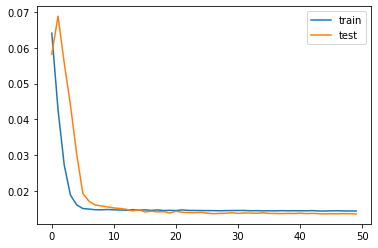

In [21]:
# plot history
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

In [34]:
yhat = model.predict(test_X)
test_X = test_X.reshape((test_X.shape[0], test_X.shape[2]))
# invert scaling for forecast
inv_yhat = concatenate((yhat, test_X[:, 1:]), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]
# invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))
inv_y = concatenate((test_y, test_X[:, 1:]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]
# calculate RMSE
rmse = sqrt(mean_squared_error(inv_y, inv_yhat))
print('Test RMSE: %.3f' % rmse)

Test RMSE: 26.528
